# Setup

In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.sql import functions as F


spark = SparkSession.builder.master('local[*]').getOrCreate()
#spark.conf.set('spark.cores.max', '1')
#spark.conf.set('spark.driver.memory','1000M')

sc = spark.sparkContext

spark

## Lectura datos

In [2]:
df_orig = spark.read.format("parquet").option("inferSchema", "true").option("timestampFormat", "yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load("data")

In [3]:
df_orig.count()

41169720

In [4]:
df_orig = df_orig.select(["tpep_pickup_datetime", "tpep_dropoff_datetime", "trip_distance"])

### Velocidad media por hora (DataFrames)

Cálculo de datos a usar:
- Conversión de la distancia del viaje de millas a kilómetros
- Cálculo de la duración del viaje en horas
- Cálculo de la hora de inicio del viaje (parámetro por el que se agrupará)

In [5]:
df = (
    df_orig
        # Distancia en millas a kilómetros
        .withColumn("distance", df_orig["trip_distance"] * 1.60934)
        # Duración en horas. `timestamp_diff` trunca la parte decimal, por lo que calculamos la duración en segundos
        # y la convertimos a horas manualmente
        .withColumn("duration", F.timestamp_diff("second", "tpep_pickup_datetime", "tpep_dropoff_datetime") / 3600)
        # Hora de inicio del viaje
        .withColumn("hour", F.hour("tpep_pickup_datetime"))
)

Limpieza de datos:

In [6]:
total = df.count()
invalid = df.filter(df.duration == 0).count()
print(f"Total: {total}, invalid: {invalid} ({invalid / total * 100:.4f}%)")

Total: 41169720, invalid: 11935 (0.0290%)


Hay pocos viajes inválidos (duración 0), por lo que podemos eliminarlos:

In [7]:
df_clean = df.filter(df.duration != 0)

Cálculo de la velocidad media por hora:

In [8]:
df_result = df_clean.withColumn("speed", df["distance"] / df["duration"]).groupBy("hour").avg("speed")

Resultados obtenidos:

In [9]:
df_result.sort(df_result.hour.asc()).toPandas()

,hour,avg(speed)
0,0,28.102599
1,1,29.394897
2,2,25.968224
3,3,43.064120
4,4,75.292156
5,5,181.852958
6,6,105.125626
7,7,76.886155
8,8,41.459151
9,9,28.072524


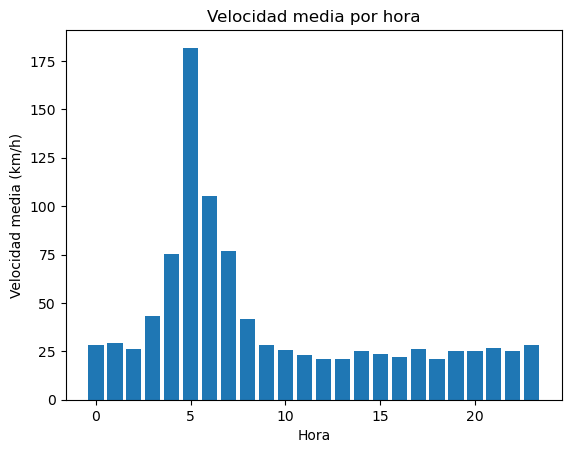

In [10]:
import matplotlib as mpl
import matplotlib.pyplot as plt
data = df_result.collect()

x = [x.hour for x in data]
y = [x["avg(speed)"] for x in data]

plt.bar(x, y)
plt.plot()

plt.xlabel("Hora")
plt.ylabel("Velocidad media (km/h)")
plt.title("Velocidad media por hora")
plt.show()

### Velocidad media por hora (SQL)

Obtenemos los datos y convertimos los datos en una vista de sql

In [11]:
df_orig = spark.read.format("parquet").option("inferSchema", "true").option("timestampFormat", "yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load("data")
df_orig.createOrReplaceTempView("yellow_trip_orig")

Ahora procedemos a convertir la distancia de millas a km y de nuevo creamos una nueva vista

In [12]:
df_sql = spark.sql("SELECT tpep_pickup_datetime, tpep_dropoff_datetime, trip_distance * 1.60934 AS trip_distance_km FROM yellow_trip_orig").createOrReplaceTempView("yellow_trip_dist_km")

A continuación calculamos la duración del viaje y obtenemos de la fecha de recogida la hora

In [13]:
df = spark.sql("SELECT trip_distance_km, (unix_timestamp(tpep_dropoff_datetime) - unix_timestamp(tpep_pickup_datetime)) / 3600 AS duration_hours, hour(tpep_pickup_datetime) AS hour FROM yellow_trip_dist_km")
df.createOrReplaceTempView("yellow_trip")

Realizamos un limpieza de datos

In [14]:
total = df.count()
invalid = df.filter("duration_hours = 0").count()
print(f"Total: {total}, invalid: {invalid} ({invalid / total * 100:.4f}%)")

Total: 41169720, invalid: 11935 (0.0290%)


In [15]:
df = spark.sql("Select trip_distance_km, duration_hours, hour from yellow_trip Where duration_hours != 0")
df.show(10)
df.createOrReplaceTempView("yellow_trip_clean")

+------------------+--------------------+----+
|  trip_distance_km|      duration_hours|hour|
+------------------+--------------------+----+
|           4.82802|               0.295|   0|
|3.5405480000000003| 0.21805555555555556|   0|
|          4.345218| 0.15166666666666667|   0|
|4.9889540000000006| 0.18083333333333335|   0|
|               0.0|0.004722222222222222|   0|
|         1.5610598| 0.07777777777777778|   0|
|          2.092142| 0.10111111111111111|   0|
|           0.80467| 0.04138888888888889|   0|
|1.7702740000000001|0.059722222222222225|   0|
|3.5405480000000003|  0.1461111111111111|   0|
+------------------+--------------------+----+
only showing top 10 rows


Obtenemos la velocidad media por hora

In [16]:
df = spark.sql("Select hour, AVG(trip_distance_km / duration_hours) AS avg_speed FROM yellow_trip_clean GROUP BY hour Order By (hour)")

Obtenemos los resultados

In [17]:
df.toPandas()

,hour,avg_speed
0,0,28.102599
1,1,29.394897
2,2,25.968224
3,3,43.064120
4,4,75.292156
5,5,181.852958
6,6,105.125626
7,7,76.886155
8,8,41.459151
9,9,28.072524


# Análisis de rendimiento

Definimos cada una de las implementaciones a analizar como funciones parametrizadas, para facilitar las pruebas:

In [18]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.sql import functions as F

spark.stop()

def setup(cores):
    return SparkSession.builder.master(f'local[{cores}]').getOrCreate()

def read(spark):
    return spark.read.format("parquet").option("inferSchema", "true").option("timestampFormat", "yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load("data")

def data_frames(cores):
    spark = setup(cores)
    df_orig = read(spark)
    df_orig = df_orig.select(["tpep_pickup_datetime", "tpep_dropoff_datetime", "trip_distance"])
    df = (
        df_orig
            .withColumn("distance", df_orig["trip_distance"] * 1.60934)
            .withColumn("duration", F.timestamp_diff("second", "tpep_pickup_datetime", "tpep_dropoff_datetime") / 3600)
            .withColumn("hour", F.hour("tpep_pickup_datetime"))
    )
    df_result = df.filter(df.duration != 0).withColumn("speed", df["distance"] / df["duration"]).groupBy("hour").avg("speed")
    res = df_result.sort(df_result.hour.asc()).toPandas()
    spark.stop()
    return res

def sql(cores):
    spark = setup(cores)
    df_orig = read(spark)
    df_orig.createOrReplaceTempView("yellow_trip_orig")
    df_sql = spark.sql("SELECT tpep_pickup_datetime, tpep_dropoff_datetime, trip_distance * 1.60934 AS trip_distance_km FROM yellow_trip_orig").createOrReplaceTempView("yellow_trip_dist_km")
    df = spark.sql("SELECT trip_distance_km, (unix_timestamp(tpep_dropoff_datetime) - unix_timestamp(tpep_pickup_datetime)) / 3600 AS duration_hours, hour(tpep_pickup_datetime) AS hour FROM yellow_trip_dist_km")
    df.createOrReplaceTempView("yellow_trip")
    df = spark.sql("Select trip_distance_km, duration_hours, hour from yellow_trip Where duration_hours != 0")
    df.createOrReplaceTempView("yellow_trip_clean")
    df = spark.sql("Select hour, AVG(trip_distance_km / duration_hours) AS avg_speed FROM yellow_trip_clean GROUP BY hour Order By (hour)")
    res = df.toPandas()
    spark.stop()
    return res
    

Medimos el rendimiento para diferentes cantidades de hilos:

In [19]:
import time

y = []
for func in (data_frames, sql):
    res = []
    for i in range(1, 9):
        t1 = time.time()
        func(i)
        t2 = time.time()
        res.append(t2 - t1)
    y.append(res)
x = list(range(1, 9))

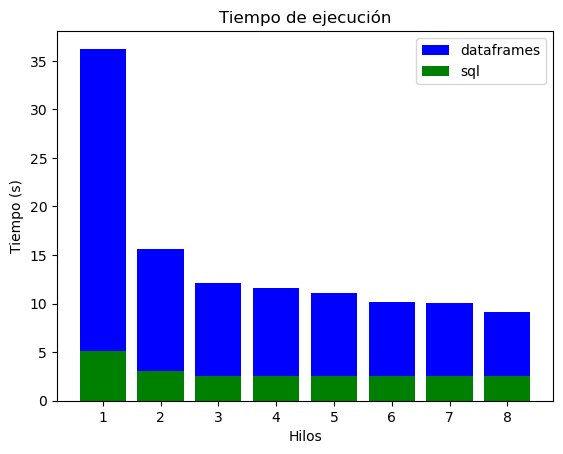

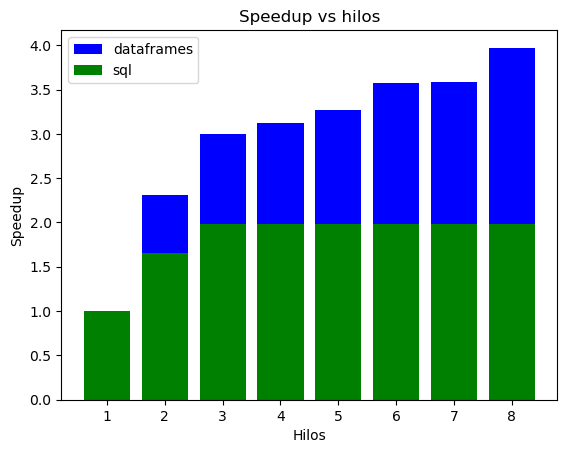

In [21]:
import matplotlib as mpl
import matplotlib.pyplot as plt

bars = [("dataframes", "b"), ("sql", "g")]

for i, (label, color) in enumerate(bars):
    plt.bar(x, y[i], label=label, color=color)
plt.plot()

plt.xlabel("Hilos")
plt.ylabel("Tiempo (s)")
plt.title("Tiempo de ejecución")
plt.legend()
plt.show()

for i, (label, color) in enumerate(bars):
    plt.bar(x, [y[i][0]/t for t in y[i]], label=label, color=color)
plt.plot()

plt.xlabel("Hilos")
plt.ylabel("Speedup")
plt.title("Speedup vs hilos")
plt.legend()
plt.show()